### **Convolutional Neural Network (CNN) for Image Classification**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2024-07-28 12:53:14.318678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Only when you are running on a GPU

physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


In [3]:
os.getcwd()

'/Users/kubzal/tensorflow_keras'

In [4]:
# Organize data into train, valid, test dirs

os.chdir("data/dogs-vs-cats")
if os.path.isdir("train/dog") is False:
    os.makedirs("train/dog")
    os.makedirs("train/cat")
    os.makedirs("valid/dog")
    os.makedirs("valid/cat")
    os.makedirs("test/dog")
    os.makedirs("test/cat")

    # Train
    for c in random.sample(glob.glob("cat*"), 500):
        shutil.move(c, "train/cat")

    for c in random.sample(glob.glob("dog*"), 500):
        shutil.move(c, "train/dog")

    # Valid
    for c in random.sample(glob.glob("cat*"), 100):
        shutil.move(c, "valid/cat")

    for c in random.sample(glob.glob("dog*"), 100):
        shutil.move(c, "valid/dog")

    # Test
    for c in random.sample(glob.glob("cat*"), 50):
        shutil.move(c, "test/cat")

    for c in random.sample(glob.glob("dog*"), 50):
        shutil.move(c, "test/dog")

os.chdir("../..")

In [38]:
train_path = "data/dogs-vs-cats/train"
valid_path = "data/dogs-vs-cats/valid"
test_path = "data/dogs-vs-cats/test"

torvi_path = "data/dogs-vs-cats/torvi"

In [39]:
train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10
)

valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path, target_size=(224, 224), classes=["cat", "dog"], batch_size=10
)

test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    classes=["cat", "dog"],
    batch_size=10,
    shuffle=False,
)

torvi_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=torvi_path,
    target_size=(224, 224),
    classes=["cat", "dog"],
    batch_size=10,
    shuffle=False,
)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [8]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert (
    train_batches.num_classes
    == valid_batches.num_classes
    == test_batches.num_classes
    == 2
)

In [9]:
# Grabbing single batch of images
imgs, labels = next(train_batches)

In [10]:
# This function will plot images in the form of a grid
# with 1 row and 10 columns where images are placed in each column


def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..142.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-108.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-113.779..123.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-118.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data

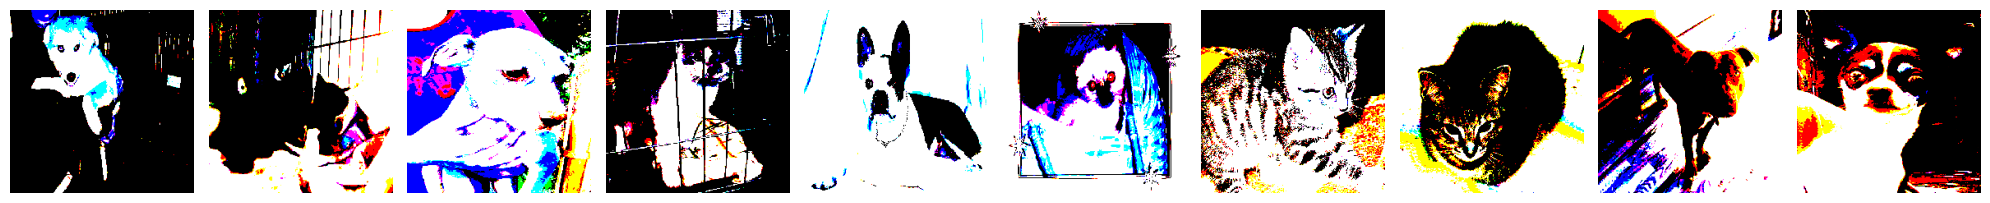

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [11]:
plotImages(imgs)
print(labels)

In [12]:
# DeepLizard --> on the blog there is inf owhat to do if you do not have labels for the images

### **Build and train a CNN**

In [13]:
model = Sequential(
    [
        Conv2D(
            filters=32,
            kernel_size=(3, 3),
            activation="relu",
            padding="same",
            input_shape=(224, 224, 3),
        ),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(units=2, activation="softmax"),
    ]
)

/Users/kubzal/tensorflow_keras/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# TO DO
# - Conv2D read about it and Convolutional Neural Networks (and Layers)
# - MaxPool2D read about it and Pooling Layers
# - Flatten read about it and Dense Layers
# - Dense read about it and Fully Connected Layers
# - softmax read about it and Activation Functions
# - relu read about it and Activation Functions
# (https://www.tensorflow.org/api_docs/python/tf/keras/activations)
# (Deep Learning Fundamentals with Keras - DeepLizard)

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       401,410 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 420,802 (1.61 MB)

 Trainable params: 420,802 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
896 + 18496 + 401410

420802

In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [17]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10


/Users/kubzal/tensorflow_keras/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 31s - 307ms/step - accuracy: 0.5180 - loss: 23.8008 - val_accuracy: 0.5450 - val_loss: 10.0829
Epoch 2/10
100/100 - 27s - 268ms/step - accuracy: 0.7220 - loss: 3.3163 - val_accuracy: 0.5400 - val_loss: 5.1926
Epoch 3/10
100/100 - 27s - 274ms/step - accuracy: 0.8560 - loss: 0.8762 - val_accuracy: 0.5100 - val_loss: 5.2373
Epoch 4/10
100/100 - 32s - 322ms/step - accuracy: 0.9000 - loss: 0.4663 - val_accuracy: 0.6450 - val_loss: 2.8155
Epoch 5/10
100/100 - 28s - 280ms/step - accuracy: 0.9660 - loss: 0.1118 - val_accuracy: 0.5800 - val_loss: 3.5084
Epoch 6/10
100/100 - 27s - 269ms/step - accuracy: 0.9850 - loss: 0.0535 - val_accuracy: 0.5900 - val_loss: 3.0747
Epoch 7/10
100/100 - 27s - 269ms/step - accuracy: 0.9930 - loss: 0.0158 - val_accuracy: 0.5700 - val_loss: 3.1911
Epoch 8/10
100/100 - 28s - 277ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.5850 - val_loss: 2.9016
Epoch 9/10
100/100 - 27s - 271ms/step - accuracy: 1.0000 - loss: 6.8336e-04 - val_accuracy: 0.620

### **Save Model**

In [19]:
# Check first to see if file exists already
# If not, the model is saved to disk.

import os.path

if os.path.isfile("models/dogs-vs-cats-cnn-small.h5") is False:
    model.save("models/dogs-vs-cats-cnn-small.h5")

In [20]:
# from tensorflow.keras.models import load_model
# model = load_model("models/dogs-vs-cats-cnn-small.h5")

### **Predict**

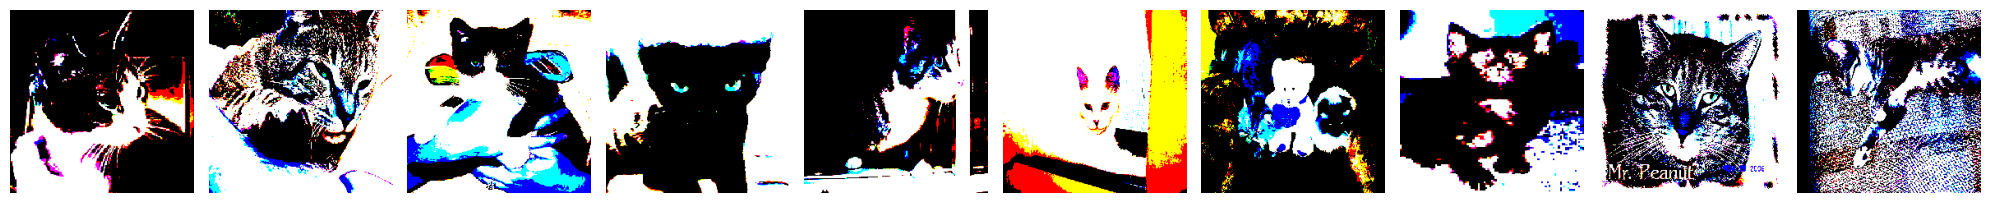

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [22]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [23]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [47]:
predictions = model.predict(x=test_batches, verbose=0)

/Users/kubzal/tensorflow_keras/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [48]:
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.

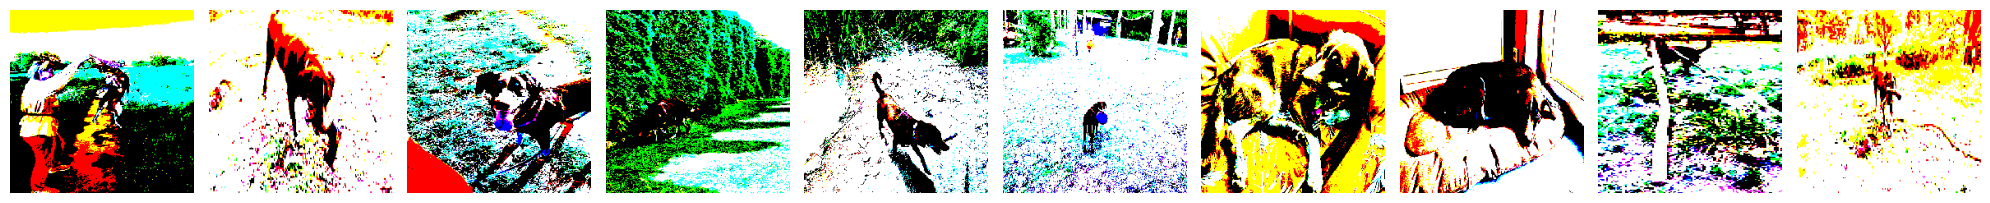

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [40]:
torvi_imgs, torvi_labels = next(torvi_batches)
plotImages(torvi_imgs)
print(torvi_labels)

In [50]:
model.predict(x=torvi_batches, verbose=0).round(2)

array([[0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.34, 0.66],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ]], dtype=float32)

In [52]:
cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

In [54]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting '
    normalize=True.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(ticks=tick_marks, labels=classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",  # Corrected typo here
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [55]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[32 18]
 [18 32]]


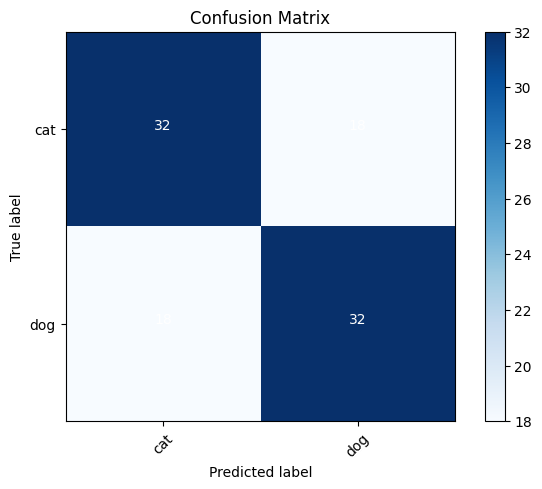

In [56]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

### **Build Fine-tuned VGG16 model**

In [57]:
# Download the model
vgg16_model = tf.keras.applications.vgg16.VGG16()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [58]:
vgg16_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
def count_params(model):
    non_trainable_params = np.sum(
        [np.prod(v.shape) for v in model.non_trainable_weights]
    )
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    return {
        "non_trainable_params": non_trainable_params,
        "trainable_params": trainable_params,
    }

In [71]:
params = count_params(vgg16_model)

assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 138_357_544

In [61]:
type(vgg16_model)

keras.src.models.functional.Functional

In [80]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [81]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:
params = count_params(model)

assert params["non_trainable_params"] == 0
assert params["trainable_params"] == 134_260_544

In [86]:
# VGG16 model is trained on 1000 classes, we only have 2 classes

for layer in model.layers:
    layer.trainable = False

In [87]:
model.add(Dense(units=2, activation="softmax"))

In [88]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [89]:
params = count_params(model)

assert params["non_trainable_params"] == 134_260_544
assert params["trainable_params"] == 8194

### **Train the fine-tuned VGG16 model**

In [90]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [91]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)

Epoch 1/5


/Users/kubzal/tensorflow_keras/env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 - 187s - 2s/step - accuracy: 0.8800 - loss: 0.2997 - val_accuracy: 0.9650 - val_loss: 0.1027
Epoch 2/5
100/100 - 175s - 2s/step - accuracy: 0.9630 - loss: 0.0879 - val_accuracy: 0.9700 - val_loss: 0.0839
Epoch 3/5
100/100 - 166s - 2s/step - accuracy: 0.9780 - loss: 0.0535 - val_accuracy: 0.9750 - val_loss: 0.0816
Epoch 4/5
100/100 - 166s - 2s/step - accuracy: 0.9890 - loss: 0.0387 - val_accuracy: 0.9700 - val_loss: 0.0868
Epoch 5/5
100/100 - 165s - 2s/step - accuracy: 0.9930 - loss: 0.0284 - val_accuracy: 0.9700 - val_loss: 0.0866


### **Save Model**

In [92]:
# Check first to see if file exists already
# If not, the model is saved to disk.

import os.path

if os.path.isfile("models/dogs-vs-cats-vgg16.h5") is False:
    model.save("models/dogs-vs-cats-vgg16.h5")

In [93]:
assert model.history.history.get("accuracy")[-1] > 0.95

### **Predict using fine-tuned VGG16 model**

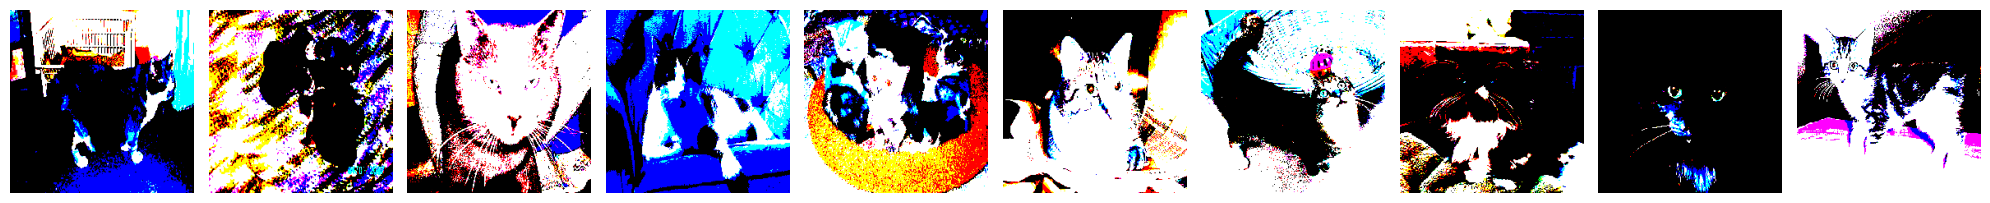

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [94]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [95]:
predictions = model.predict(x=test_batches, verbose=0)

In [97]:
np.round(predictions, 2)

array([[0.99, 0.01],
       [0.17, 0.83],
       [1.  , 0.  ],
       [0.96, 0.04],
       [0.97, 0.03],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.94, 0.06],
       [0.95, 0.05],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.97, 0.03],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [0.83, 0.17],
       [1.  , 0.  ],
       [0.99, 0.01],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.97, 0.03],
       [0.9 , 0.1 ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  ,

In [96]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [100]:
cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

In [102]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[49  1]
 [ 1 49]]


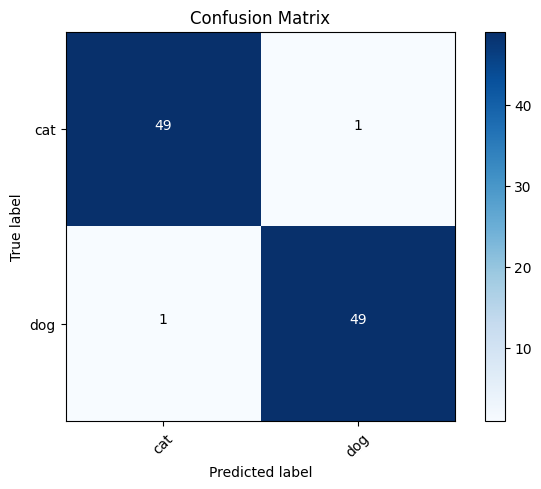

In [101]:
cm_plot_labels = ["cat", "dog"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

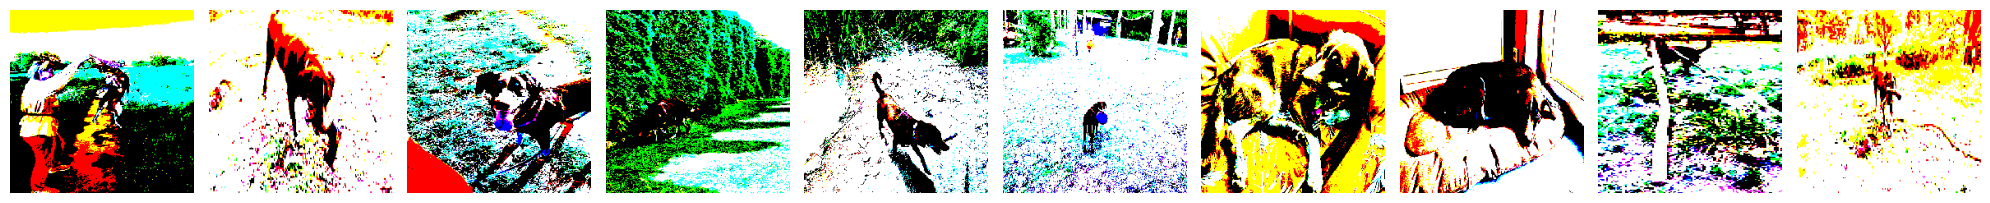

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [98]:
torvi_imgs, torvi_labels = next(torvi_batches)
plotImages(torvi_imgs)
print(torvi_labels)

In [99]:
model.predict(x=torvi_batches, verbose=0).round(2)

array([[0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.14, 0.86],
       [0.01, 0.99],
       [0.  , 1.  ]], dtype=float32)